### Smartphone user behavior: <br>Does the number of apps influence the time (screen on Time & ) users spend on their phones?


### Packages


In [222]:
#00: Import all required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import time

sns.set_theme(style='white', palette='muted', font='sans-serif', font_scale=1, color_codes=True, rc=None)

### Load Dataset


In [223]:
#01: Load the Dataset
data_path = 'user_behavior_dataset.csv'
data = pd.read_csv(data_path)

### Data Preparation


In [224]:
print("Dataset Overview:")
data.head()

Dataset Overview:


,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [225]:
# shape
data.shape

(700, 11)

In [226]:
# Inspect Dataset data types & non-null values
print("\n Dataset Information:")
data.info()


 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [227]:
# description
data.describe()

,User ID,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class
count,700.00000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,350.50000,271.128571,5.272714,1525.158571,50.681429,929.742857,38.482857,2.990000
std,202.21688,177.199484,3.068584,819.136414,26.943324,640.451729,12.012916,1.401476
min,1.00000,30.000000,1.000000,302.000000,10.000000,102.000000,18.000000,1.000000
25%,175.75000,113.250000,2.500000,722.250000,26.000000,373.000000,28.000000,2.000000
50%,350.50000,227.500000,4.900000,1502.500000,49.000000,823.500000,38.000000,3.000000
75%,525.25000,434.250000,7.400000,2229.500000,74.000000,1341.000000,49.000000,4.000000
max,700.00000,598.000000,12.000000,2993.000000,99.000000,2497.000000,59.000000,5.000000


In [228]:
# Check null Data
print("\n Missing Values:")
data.isnull().sum()


 Missing Values:


User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

In [229]:
# Check duplicate data
data.duplicated().sum()

0

In [230]:
# Drop duplicate, Drop null or missing values rows
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [231]:
# Selecting relevant columns and renaming
data = data[[
        'User ID',
        'App Usage Time (min/day)',
        'Screen On Time (hours/day)',
        'Number of Apps Installed',
        'Age','Gender',
        'User Behavior Class'
        ]]
data.columns = ['user_id', 'app_usage', 'screen_time', 'num_apps','age', 'gender', 'behave_class']
data.head()

,user_id,app_usage,screen_time,num_apps,age,gender,behave_class
0,1,393,6.4,67,40,Male,4
1,2,268,4.7,42,47,Female,3
2,3,154,4.0,32,42,Male,2
3,4,239,4.8,56,20,Male,3
4,5,187,4.3,58,31,Female,3


### Exploratory Data Analysis


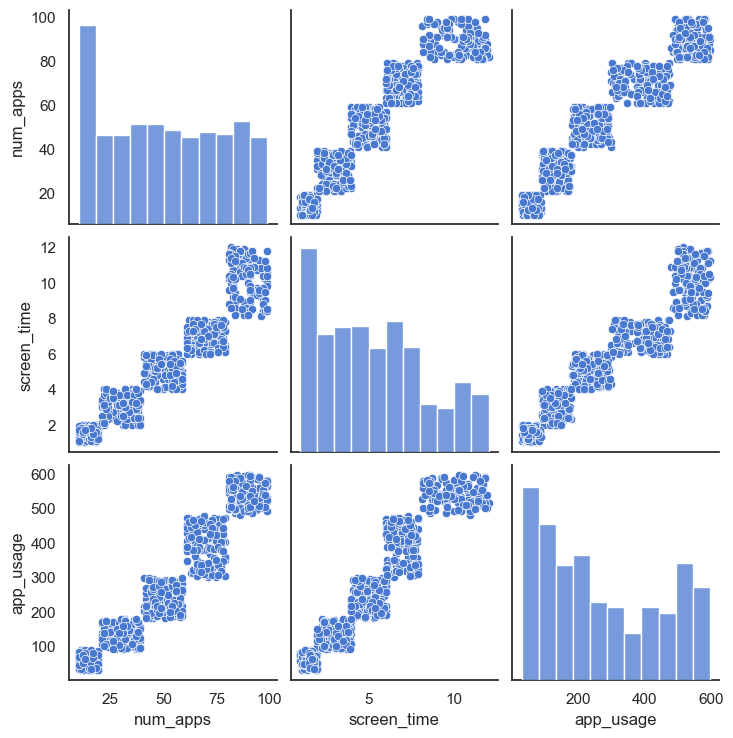

In [232]:
# Data visualization
# Early check for relationships between the three features
sns.pairplot(data[['num_apps', 'screen_time', 'app_usage']])
plt.show()

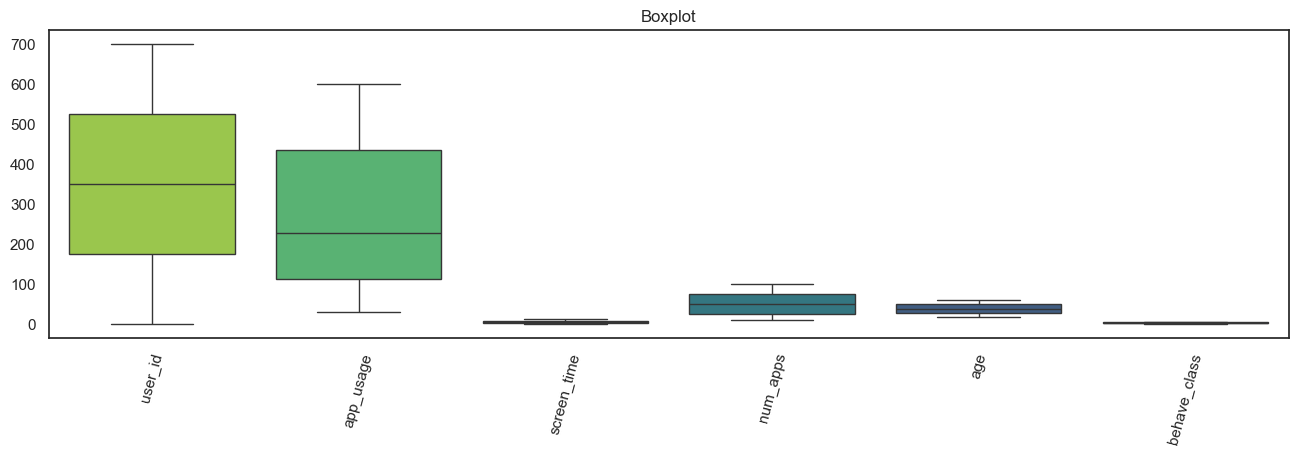

In [233]:
# Check for outliers in the data
# Boxplots
plt.figure(figsize=(16,4))
sns.boxplot(data.iloc[:,:], palette='viridis_r')
plt.xticks(rotation=75)
plt.title("Boxplot")
plt.show()

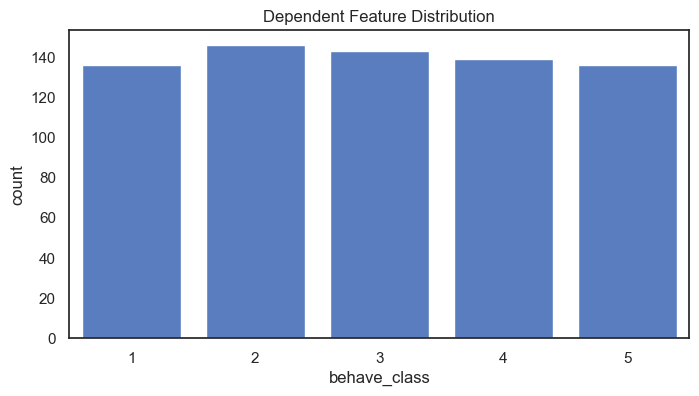

In [234]:
# Analyzing Distribution of Dependent Feature
plt.figure(figsize=(8,4))
sns.countplot(data=data, x='behave_class')
plt.title("Dependent Feature Distribution")
plt.show()

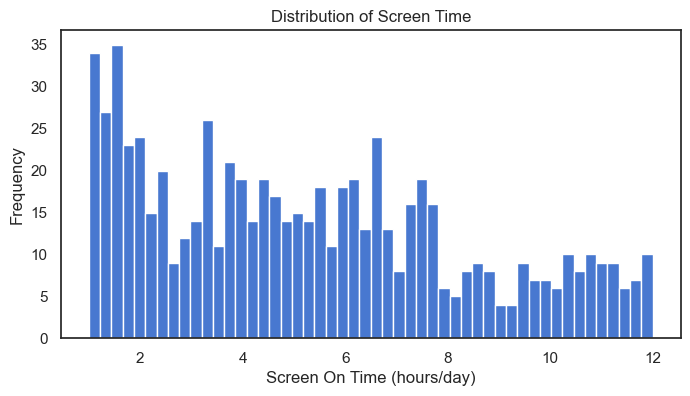

count    700.000000
mean       5.272714
std        3.068584
min        1.000000
25%        2.500000
50%        4.900000
75%        7.400000
max       12.000000
Name: screen_time, dtype: float64

In [235]:
# Distribution of screen on time

plt.figure(figsize=(8, 4))

plt.hist(data['screen_time'], bins=50)
plt.title('Distribution of Screen Time')
plt.xlabel('Screen On Time (hours/day)')
plt.ylabel('Frequency')
plt.show()

data['screen_time'].describe()

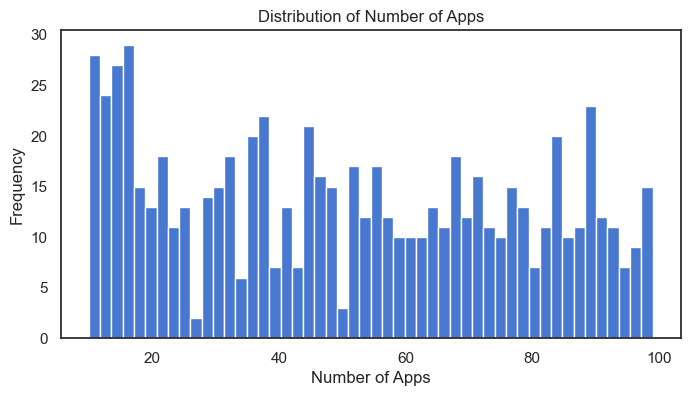

count    700.000000
mean      50.681429
std       26.943324
min       10.000000
25%       26.000000
50%       49.000000
75%       74.000000
max       99.000000
Name: num_apps, dtype: float64

In [236]:
# Distribution of the number of apps per user

plt.figure(figsize=(8,4))

plt.hist(data['num_apps'], bins=50)
plt.title('Distribution of Number of Apps')
plt.xlabel('Number of Apps')
plt.ylabel('Frequency')
plt.show()

data['num_apps'].describe()

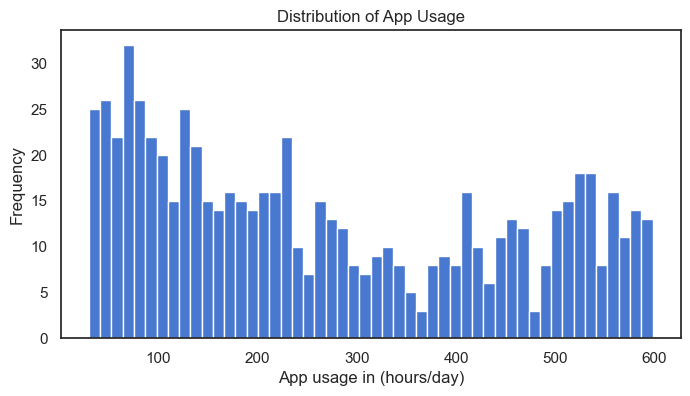

count    11.666667
mean      4.518810
std       2.953325
min       0.500000
25%       1.887500
50%       3.791667
75%       7.237500
max       9.966667
Name: app_usage, dtype: float64

In [237]:
# Distribution of app usage per user

plt.figure(figsize=(8,4))

plt.hist(data['app_usage'], bins=50)
plt.title('Distribution of App Usage')
plt.xlabel('App usage in (hours/day)')
plt.ylabel('Frequency')

plt.show()

data['app_usage'].describe()/60

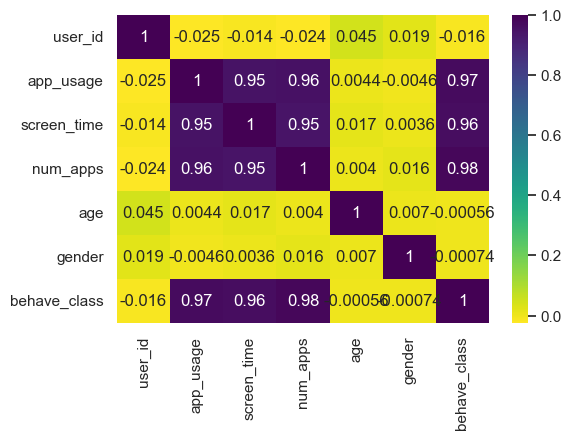

In [238]:
# Relationship Between Features
# Examines the correlation between features.

# # Assign genders statistical values 0, 1
data['gender'] = data['gender'].map({"Male":1, "Female":0})

# Using a Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), annot=True, cmap="viridis_r")
plt.show()

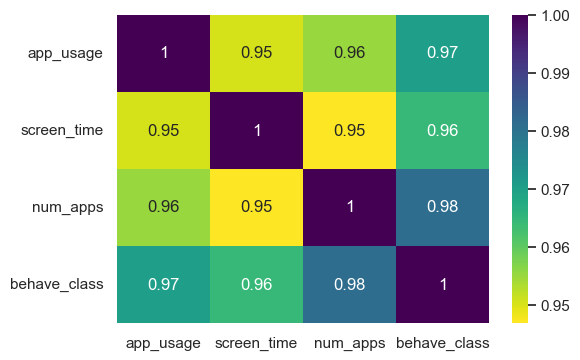

In [239]:
# Drop low correlation column/features
# From above, user_id, Age and Gender have very low correlation below 0.5
data.drop(columns=['user_id', 'age', 'gender'], axis=1, inplace=True)

# Visualize correlation matrix again
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), annot=True, cmap="viridis_r")
plt.show()

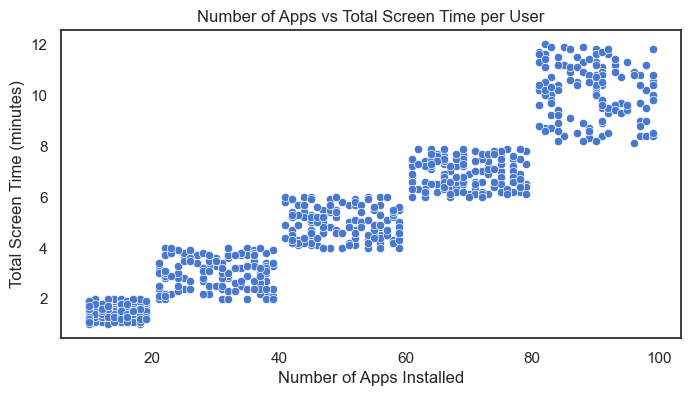

In [240]:
# Number of Apps installed vs Screen On Time (hours/day)
# Scatter Plot
plt.figure(figsize=(8, 4))
sns.scatterplot(data=data, x='num_apps', y='screen_time')
plt.title('Number of Apps vs Total Screen Time per User')
plt.xlabel('Number of Apps Installed')
plt.ylabel('Total Screen Time (minutes)')
plt.show()

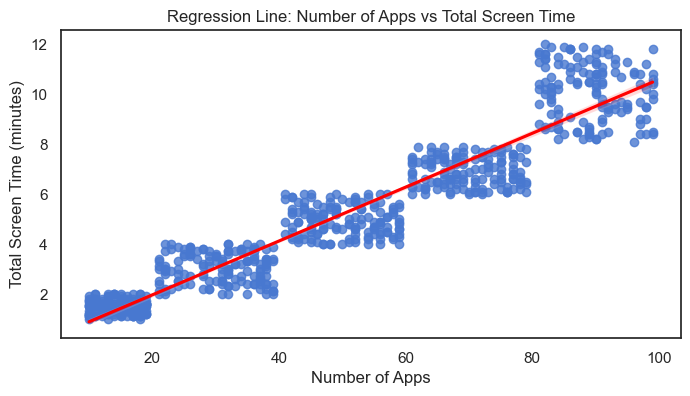

In [241]:
# Regression Line
plt.figure(figsize=(8, 4))
sns.regplot(data=data, x='num_apps', y='screen_time', line_kws={'color': 'red'})
plt.title('Regression Line: Number of Apps vs Total Screen Time')
plt.xlabel('Number of Apps')
plt.ylabel('Total Screen Time (minutes)')
plt.show()

In [242]:
# Correlation Analysis
spearman_corr, spearman_pval = spearmanr(data['num_apps'], data['screen_time'])

print(f"Spearman Correlation: {spearman_corr:.2f} (p-value: {spearman_pval:.3f})")

Spearman Correlation: 0.96 (p-value: 0.000)


### Feature Engineering


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        43
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        44

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210

Accuracy: 100%


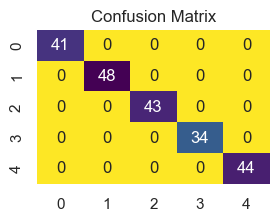

,feature,importance
2,num_apps,0.335911
0,app_usage,0.332356
1,screen_time,0.331732


In [ ]:
# Random Forest Classifier
# ************************
# The predictors for the 'User Behavior Class' (renamed to 'behave_class') are likely:
# 'app_usage', 'screen_time', 'num_apps'.

X = data[['app_usage', 'screen_time', 'num_apps']]
y = data['behave_class']

# Split data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Model Performance Evaluation
print(f"Accuracy: {round(accuracy_score(y_test, y_pred)*100)}%")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, cmap='viridis_r', cbar=False)
plt.title("Confusion Matrix")
plt.show()

# Check for feature importance
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

In [244]:
# Feature Engineering
# The result above shows screen_time with the highest importance towards determination of user behavior class.
# Now we can create a predictive model for the influence of number of apps on screen time which can be used to assign a behavior class.

# Extract features.
X = data[['num_apps']]
y = data['screen_time']

# Polynomial Features improve model performance
# To raise the num_apps feature to power 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=40)

# Standardization
# Standard transformation on the data to create a zero mean and variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modelling



Model Performance:
                        RMSE        R2      Time
Random Forest      0.834164  0.927351  0.081669
Linear Regression  0.923022  0.911049  0.000699


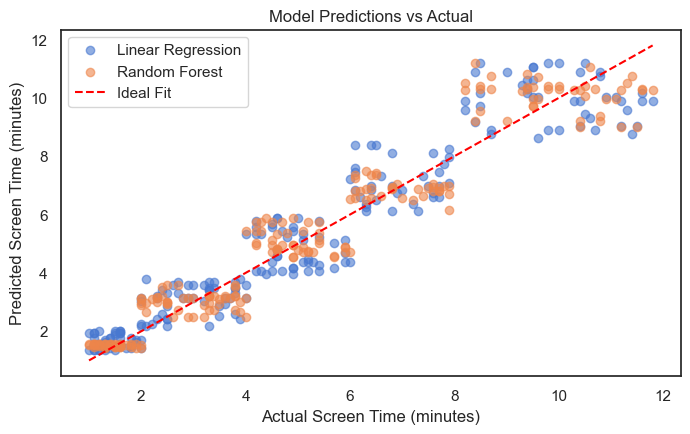

In [245]:
# Model Selection

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Model Training & Evaluation
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    end_time = time.time()
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    results[name] = {'RMSE': rmse, 'R2': r2, 'Time': end_time - start_time}

# Display results
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print("\nModel Performance:\n", results_df)

# Visualization of Predictions
plt.figure(figsize=(8, 4.5))
for name, model in models.items():
    predictions = model.predict(X_test_scaled)
    plt.scatter(y_test, predictions, alpha=0.6, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Screen Time (minutes)')
plt.ylabel('Predicted Screen Time (minutes)')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.show()